In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# The Data

Now is when we begin building out models to predict salary based on player's statistics

The dependent variable for this study was NBA player salaries and the independent variables were the offensive and defensive statistical categories.

We are going to use the salaries and statistics of 486 NBA players from the 2016-2017 season. I decided to only use the statistics from the 2016-2017 season as they would be most reflective of the current salary rates. The salary cap for the NBA has been increasing at a rate faster than inflation and so it wouldn't make for a good model to bring in statistics from multiple years. I thought about bringing in "year" as a feature so that the model would give weight to the year, as well as other features. But I wanted to stick to just statistical features to predicta single salary outcome.

### Data Dictionary

- **Player**: Player Name -- TEXT
- **Position**: Position - TEXT
- **Shooting_Hand**: Hand that player shoots with -- TEXT
- **Height_inches**: Height of player -- INTEGER
- **Weight_lbs**: Weight of player -- FLOAT
- **College**: College that player played at -- TEXT
- **Draft_Year**: Year player was drafted -- INTEGER
- **Draft_Position**: Rank in draft -- INTEGER
- **Season_Count**: Number of seasons played in NBA - INTEGER
- **Age**: Age of Player at the start of February 1st of that season -- INTEGER
- **G**: Games -- INTEGER
- **GS**: Games Started -- INTEGER
- **MP**: Minutes Played -- FLOAT
- **FG**: Field Goals -- FLOAT
- **FGA**: Field Goal Attempts -- FLOAT
- **FG_Perc**: Field Goal Percentage -- FLOAT
- **Three_P**: 3-Point Field Goals -- FLOAT
- **Three_Att**: 3-Point Field Goal Attempts -- FLOAT
- **Three_Perc**: 3-Point Field Goal Percentage -- FLOAT
- **Two_P**: 2-Point Field Goals -- FLOAT
- **Two_Att**: 2-Point Field Goal Attempts -- FLOAT
- **Two_Perc**: 2-Point Field Goal Percentage -- FLOAT
- **EFG_Perc**: Effective Field Goal Percentage -- FLOAT <br>
     This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal
- **FT**: Free Throws -- FLOAT
- **FTA**: Free Throw Attempts -- FLOAT
- **FT_Perc**: Free Throw Percentage -- FLOAT
- **ORB**: Offensive Rebounds -- FLOAT
- **DRB**: Defensive Rebounds  -- FLOAT
- **TRB**: Total Rebounds -- FLOAT
- **AST**: Assists -- FLOAT
- **STL**: Steals -- FLOAT
- **BLK**: Blocks -- FLOAT
- **All_Star**: All Star status, 1 if they were all star at some point in career, 0 if not -- INTEGER
- **TOV**: Turnovers -- FLOAT
- **PF**: Personal Fouls --- FLOAT
- **PTS**: Points -- FLOAT
- **PER**: Player Efficiency Rating - FLOAT <br>
     A measure of per-minute production standardized such that the league average is 15
- **WS**: Win Shares -- FLOAT <br>
     An estimate of the number of wins contributed by a player
- **Salary**: Salary for the 2016-2017 season -- FLOAT

# Data Cleaning

Now we are going to build out some models for salary prediction. However, before we do this, we need to look at our features and set up our data for the model.

In [2]:
!pip install psycopg2

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import psycopg2 as pg2
from psycopg2.extras import RealDictCursor

def execute_query(query):  
    connection = pg2.connect(host='postgres',
                             user='postgres',
                             database='basketball')
    cursor = connection.cursor(cursor_factory=RealDictCursor)
    cursor.execute(query)
    r = cursor.fetchall()
    cursor.close()
    return r

def query_to_df(query):
    df = pd.DataFrame(execute_query(query))
    return df

In [4]:
nba_df = query_to_df('SELECT * FROM nba_2016')
nba_df.head()

,age,all_star,ast,blk,college,draft_position,draft_year,drb,efg_perc,fg,...,three_att,three_p,three_perc,tov,trb,two_att,two_p,two_perc,weight_lbs,ws
0,24,0,4.0,13.0,Purdue University,46,2016,28.0,0.464,17.0,...,10.0,5.0,0.500,10.0,36.0,32.0,12.0,0.375,260.0,0.0
1,32,0,125.0,9.0,University of Oregon,26,2007,51.0,0.483,121.0,...,128.0,48.0,0.375,66.0,69.0,172.0,73.0,0.424,161.0,0.3
2,21,0,150.0,40.0,University of Arizona,4,2014,289.0,0.499,393.0,...,267.0,77.0,0.288,89.0,405.0,598.0,316.0,0.528,220.0,3.7
3,22,0,3.0,0.0,University of Kentucky,0,0,3.0,0.000,0.0,...,2.0,0.0,0.000,0.0,3.0,2.0,0.0,0.000,210.0,0.1
4,25,0,7.0,7.0,Michigan State University,15,2014,24.0,0.454,23.0,...,15.0,3.0,0.200,8.0,33.0,39.0,20.0,0.513,237.0,0.2


In [5]:
nba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 39 columns):
age               486 non-null int64
all_star          486 non-null int64
ast               486 non-null float64
blk               486 non-null float64
college           486 non-null object
draft_position    486 non-null int64
draft_year        486 non-null int64
drb               486 non-null float64
efg_perc          485 non-null float64
fg                486 non-null float64
fg_perc           485 non-null float64
fga               486 non-null float64
ft                486 non-null float64
ft_perc           471 non-null float64
fta               486 non-null float64
g                 486 non-null float64
gs                486 non-null float64
height_inches     486 non-null float64
mp                486 non-null float64
orb               486 non-null float64
per               486 non-null float64
pf                486 non-null float64
player            486 non-null object
position

#### Dropping features not related to on-court performance
There are some features that are not related to on-court performence. There might be indicators that are related to past performence, like draft_position, which is related to how well a person did in college. But our model is more concerned about actual on-court performence at the professional level. And there are other fields that are simply not reflective of performence at all, such as shooting_hand, height and weight. So we are going to drop the following columns.

##### Drop these fields
- Player
- Position
- Shooting_Hand
- Height_inches
- Weight_lbs
- College
- Draft_Year
- Draft_Position
- All_star

In [6]:
nba_df.drop(['player','position','shooting_hand','height_inches','weight_lbs','college','draft_year','draft_position','all_star'],axis=1, inplace=True)

#### Dropping Player Efficiency Rating (PER)

PER is an advanced statistical measure of per-minute production standardized such that the league average is 15. It combines various factors but there is a major flaw with it. 

PER largely measures offensive performance. Two of the defensive statistics it incorporates—blocks and steals (which was not tracked as an official stat until 1973)—can produce a distorted picture of a player's value and that PER is not a reliable measure of a player's defensive acumen.

Therefore, it's a statistic that will add onto offensive statistics and may even "double" count it without including defensive statistical factors.

Because of this unbalance weight towards offensive statistics, we are going to drop this column.

In [7]:
nba_df.drop('per',axis=1,inplace=True)

#### Excluding rookies

From my previous notebook with EDA, seson count was a key indicator of whether a player was in their rookie contract. Age didn't really give any kind of relevant information. But season count had more explanatory power as it shows the fact that there were players who were restricted by the rookie salary cap. For rookies, their salaries are constrainted by the rookie salary cap which is typically in force for three years. Thus the swarm plot in our EDA notebook showed that there was a large swarm of lower salaries at season counts of 1-3. Therefore, we are going to exclude rookies from this data set. If a rookie or a second year player performed well statistically, they would not be compensated accordingly because they are "locked" into a contract that my not reward them for their excellent play. And the whole premise of our data

![season_count](https://raw.githubusercontent.com/michaelkim9/nba_predictor_project/master/other_assets/player_sal_season_count.png)

##### Drop these rows
- Any rookies which mean any rows that have a player with a season count lower than 3
    - 172 rookies
    - 486 total players
    - 314 players in our final data set
    
##### Drop these fields
- Age
- Season_count

In [8]:
print(nba_df.shape[0])
print(nba_df[nba_df['season_count'] > 3].shape[0])

486
314


In [9]:
nba_df = nba_df[nba_df['season_count'] > 3]

In [10]:
nba_df.drop(['age','season_count'],axis=1,inplace=True)

In [11]:
nba_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 1 to 485
Data columns (total 27 columns):
ast           314 non-null float64
blk           314 non-null float64
drb           314 non-null float64
efg_perc      314 non-null float64
fg            314 non-null float64
fg_perc       314 non-null float64
fga           314 non-null float64
ft            314 non-null float64
ft_perc       311 non-null float64
fta           314 non-null float64
g             314 non-null float64
gs            314 non-null float64
mp            314 non-null float64
orb           314 non-null float64
pf            314 non-null float64
pts           314 non-null float64
salary        314 non-null float64
stl           314 non-null float64
three_att     314 non-null float64
three_p       314 non-null float64
three_perc    296 non-null float64
tov           314 non-null float64
trb           314 non-null float64
two_att       314 non-null float64
two_p         314 non-null float64
two_perc      314 no

#### Per Game Statistics

Currently, the data has total numbers for the entire season. For example, the feature "PTS" includes all the points that the player made for all of 2016-2017. However, this might not be entirely reflective of an individual player's performance compared to someone else's because the total number doesn't compensate for any lost statistics due to injuries of suspensions. Therefore, the columns that are indicated as totals are going to be divided by the total number of games that they played so that the statistics would be "per game." And then, going to drop the columns that are related to the number of games or minutes that a player played as they aren't statistics related to player performance.

The columns that are percentages aren't affected because the percentage will remain the same whether it's a total or per-game statistic.

##### Adjust these fields to per game
- FG: Field Goals
- FGA: Field Goal Attempts 
- Three_P: 3-Point Field Goals 
- Three_Att: 3-Point Field Goal Attempts 
- Two_P: 2-Point Field Goals 
- Two_Att: 2-Point Field Goal Attempts 
- FT: Free Throws 
- FTA: Free Throw Attempts 
- ORB: Offensive Rebounds 
- DRB: Defensive Rebounds 
- TRB: Total Rebounds 
- AST: Assists 
- STL: Steals 
- BLK: Blocks 
- TOV: Turnovers 
- PF: Personal Fouls 
- PTS: Points 

##### Drop these fields
- G: Games
- GS: Games Start
- MP: Minutes Played

In [12]:
adjust_columns = [
    'fg',
    'fga',
    'three_p',
    'three_att',
    'two_p',
    'two_att',
    'ft',
    'fta',
    'orb',
    'drb',
    'trb',
    'ast',
    'stl',
    'blk',
    'tov',
    'pf',
    'pts'
]

In [13]:
for column in adjust_columns:
    nba_df[column] = nba_df[column] / nba_df['g']

In [14]:
nba_df.drop(['g','gs','mp'],axis=1,inplace=True)

#### Dropping columns that have high correlation with others

The features (stats) in our data set need to be independent from one another. From our EDA and our heatmap diagram, we noticed that there are stats columns that are highly (or even directly) correlated with one another. This will affect our model as it'll be unevenly weighting certain statistics and not others because it's appearing more than once in any given column. For example, field goals, field goal attempts and field goal percentage are directly correlated with one another. So we could take out 2 of those 3 statistics.

Heatmap to show correlations of the remaining fields below:

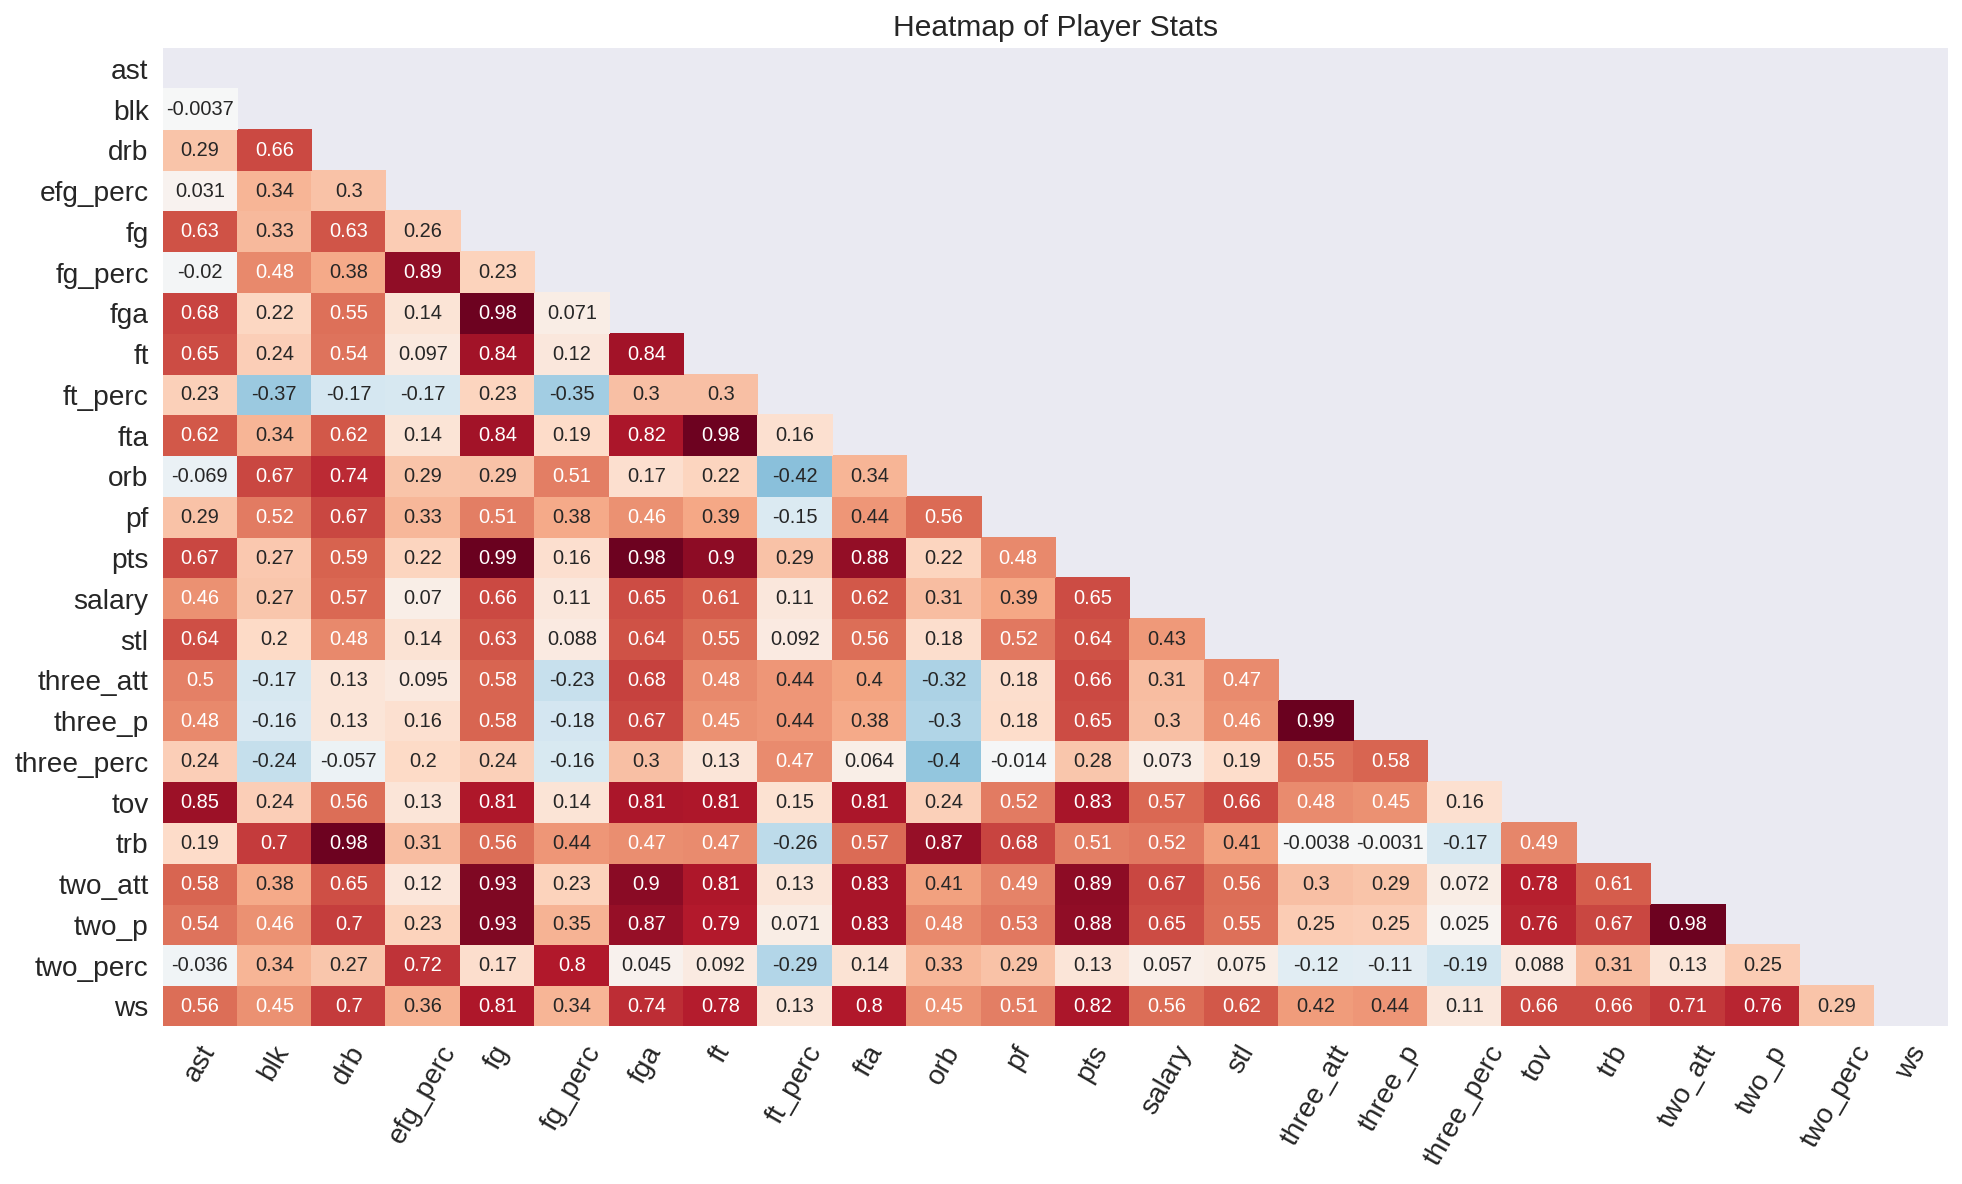

In [15]:
corrs = nba_df.corr()

fig, ax = plt.subplots(figsize = (16, 9))
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
  
ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=False)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=60)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
ax.set_title("Heatmap of Player Stats", size=15)

plt.show()

From the heatmap above, we could identify the stats columns that are highly correlated with one another and drop those columns. Going to  So we are going to drop the following.

- fg
- fga
- fg_percent
- three_p
- three_att
- three_perc
- two_p
- two_att
- two_perc
- fta
- orb
- drb
- ft 

In [16]:
nba_df.drop(['fg','fga','fg_perc','three_att','two_att','fta','orb','drb','three_p','two_p','three_perc','two_perc','ft'],axis=1,inplace=True)

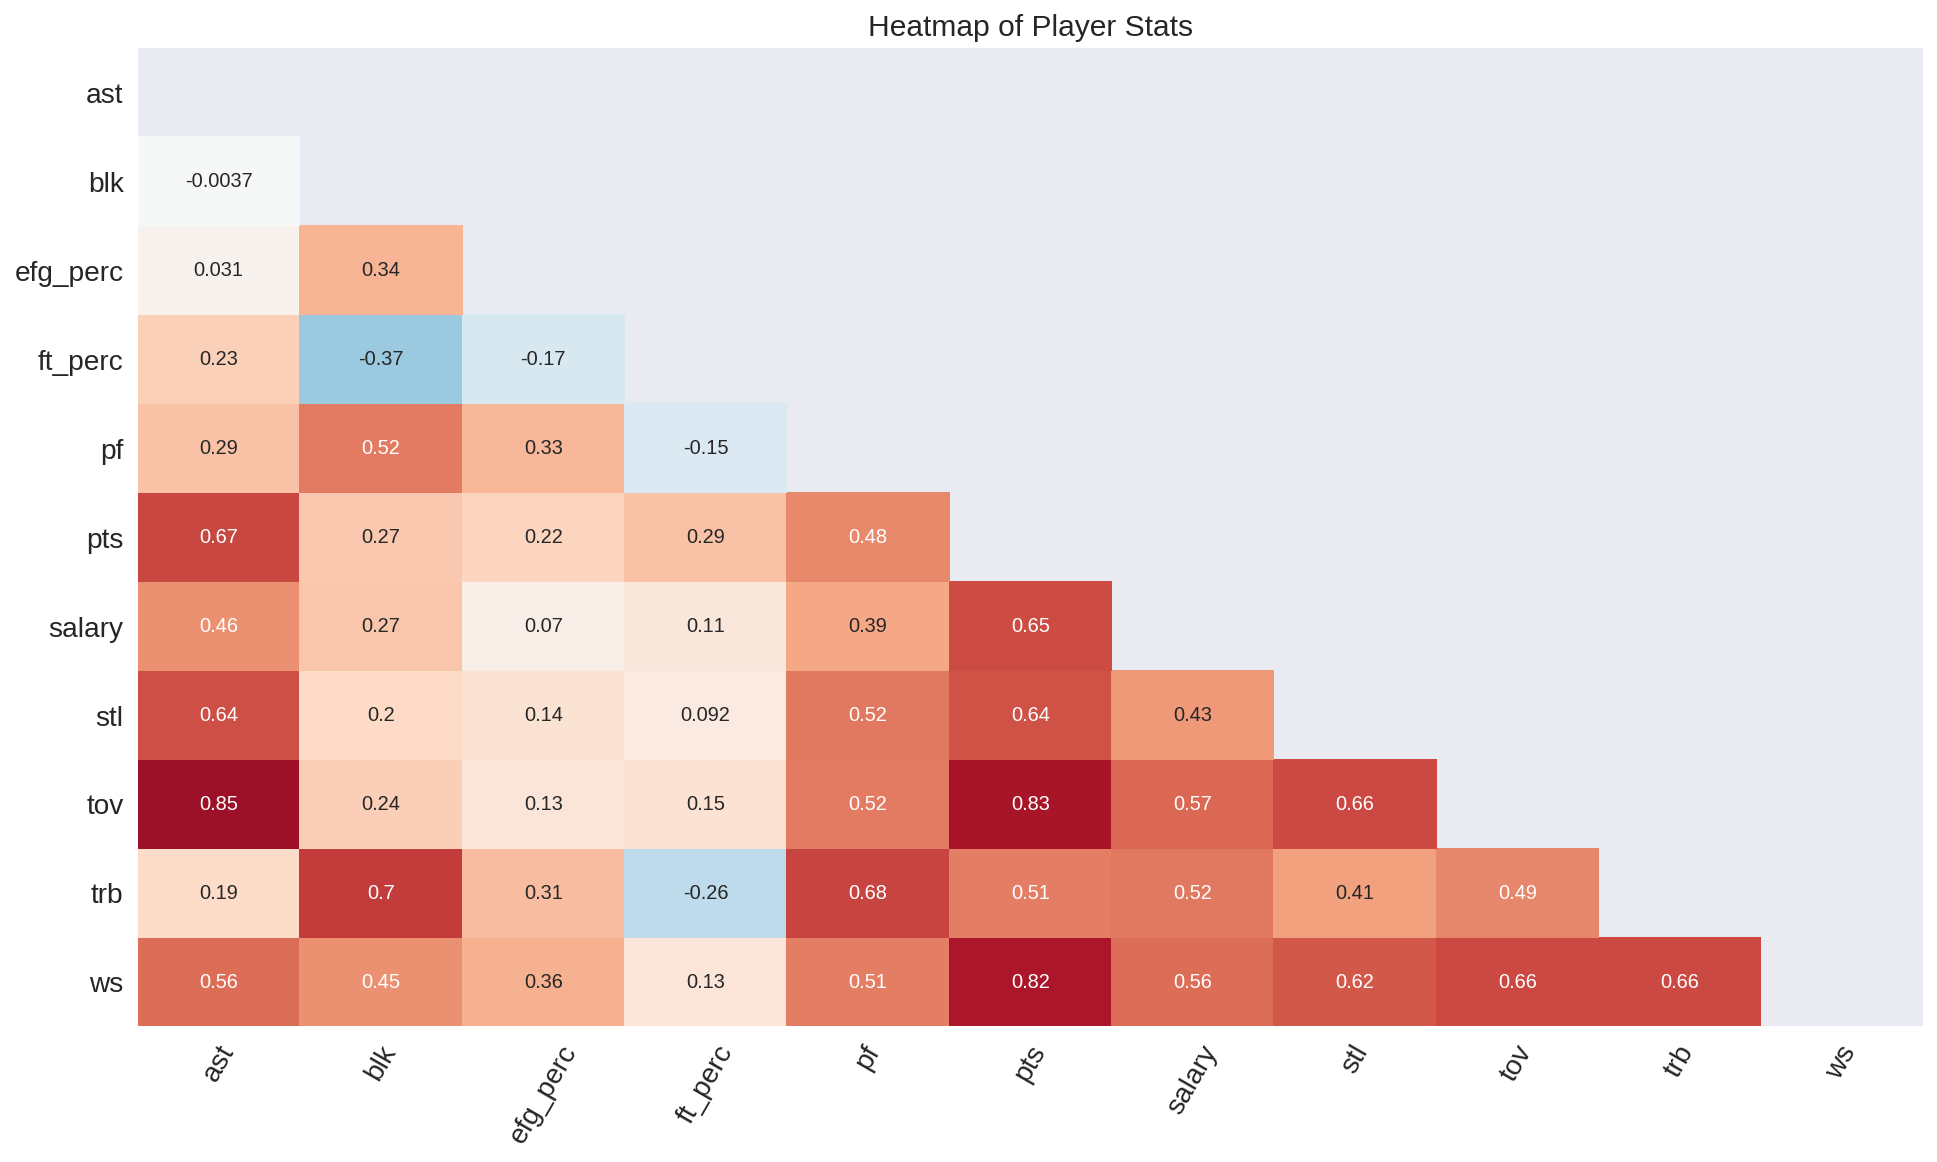

In [17]:
corrs = nba_df.corr()

fig, ax = plt.subplots(figsize = (16, 9))
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
  
ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=False)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=60)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
ax.set_title("Heatmap of Player Stats", size=15)

plt.show()

#### Fill null values

In [18]:
nba_df.fillna(0,inplace=True)

#### Our final data set

Here is a final look at our data set.

In [19]:
from sklearn.externals import joblib

In [20]:
nba_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 1 to 485
Data columns (total 11 columns):
ast         314 non-null float64
blk         314 non-null float64
efg_perc    314 non-null float64
ft_perc     314 non-null float64
pf          314 non-null float64
pts         314 non-null float64
salary      314 non-null float64
stl         314 non-null float64
tov         314 non-null float64
trb         314 non-null float64
ws          314 non-null float64
dtypes: float64(11)
memory usage: 29.4 KB


In [ ]:
joblib.dump(nba_df,'pickled_files/nba_df')

# Linear Model w/ Regularization

This is where some of the interesting stuff happens! Now we are going to build out a predictive model - starting with linear regression with regularization. Regularization is a method for adding additional constraints or penalty to a model, with the goal of preventing overfitting and improving generalization.

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [22]:
X = nba_df.drop('salary', axis=1)
y = nba_df['salary']

### Scaling and Train-Test-Split

Statistics are going to vary in scale as there are some statistics that are just going to be inherently higher values than others. For example, typically players will have more free throws than they do blocks. But the magnitude (or the number of free throws versus blocks) shouldn't determine the magnitude of the end result (salary). So I am going to scale the data so that the statistical variables are standardized by scaling to unit variance.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
import sklearn.linear_model as lm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.feature_selection import SelectFromModel

In [25]:
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(Lasso())),
    ('regr', lm.LinearRegression())
])

lr_params = {
    'sfm__estimator':[Lasso(), Ridge()]
}

lr_gs = GridSearchCV(lr_pipe,lr_params,n_jobs=-1,cv=10)

In [26]:
lr_gs.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
        prefit=False, threshold=None)), ('regr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'sfm__estimator': [Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verb

In [27]:
print(lr_gs.best_score_)
print(lr_gs.best_params_)

0.42603253841
{'sfm__estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)}


In [28]:
lr_gs.score(X_train,y_train)

0.53238285119577222

In [29]:
lr_gs.score(X_test,y_test)

0.41845627039469924

In [30]:
linear_test_preds = lr_gs.predict(X_test)
print('Linear MAE:', mean_absolute_error(linear_test_preds, y_test))
print('Linear MSE:', mean_squared_error(linear_test_preds, y_test))

Linear MAE: 3565632.94528
Linear MSE: 2.12967758194e+13


In [31]:
lr_gs_results = pd.DataFrame(lr_gs.cv_results_)
lr_gs_results.sort_values('rank_test_score', ascending=True).T

,0,1
mean_fit_time,0.013356,0.00313487
mean_score_time,0.00102272,0.000519919
mean_test_score,0.426033,0.413626
mean_train_score,0.534266,0.503318
param_sfm__estimator,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr..."
params,"{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Ridge(alpha=1.0, copy_X=Tru..."
rank_test_score,1,2
split0_test_score,0.601084,0.57044
split0_train_score,0.514488,0.483738
split1_test_score,0.286362,0.316548


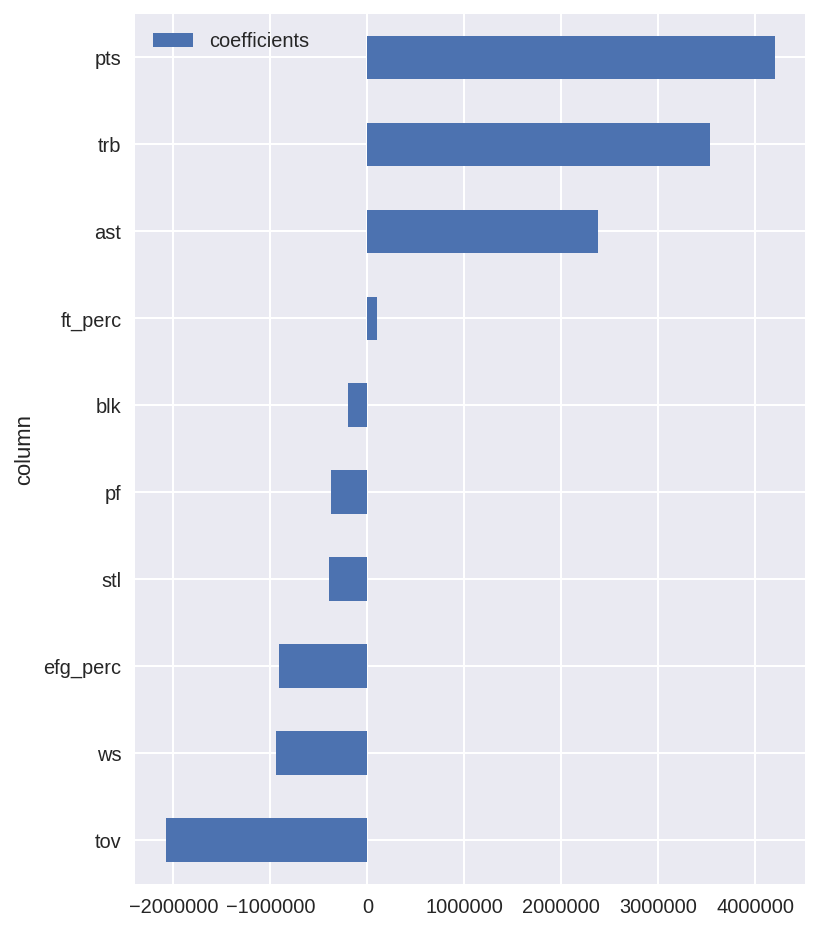

In [32]:
lr_feat_importances = lr_gs.best_estimator_.named_steps['regr'].coef_
lr_cols_and_imps = list(zip(X_train.columns, lr_feat_importances))
lr_cols_and_imps.sort(key=lambda x:x[1], reverse=False)

lr_feat_imp_df = pd.DataFrame(lr_cols_and_imps)
lr_feat_imp_df.rename(columns={1:'coefficients',0:'column'}, inplace=True)
lr_feat_imp_df = lr_feat_imp_df

lr_feat_imp_df.plot.barh('column','coefficients', figsize=(6,8))
plt.show()

#### More complex linear model: ElasticNet

The r^2 for the linear model was around 42% for the test data. The basic linear regression model may not be the best model given that basketball statistics and a player's performance have many variables and there are other factors that contribute to player's salaries. Building out a more complex model that includes these other factors could greatly imporve the accuracy of our prediction. 

Below, going to implement ElasticNet with a GridSearch and Pipeline.

In [33]:
en_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(Lasso())),
    ('regr', ElasticNet())
])

en_params = {
    'sfm__estimator':[Lasso(), Ridge()],
    'regr__l1_ratio':[.1,.3,.5,.7,.9],
    'regr__alpha':np.linspace(0,1,20)
}

en_gs = GridSearchCV(en_pipe,
                      param_grid=en_params,
                      n_jobs=-1,
                      cv = ShuffleSplit(random_state=42)
                     )

In [34]:
en_gs.fit(X_train,y_train)

/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advise

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algori

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression e

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: 

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Co

/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarn

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression e

/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.5/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coor

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'regr__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'regr__alpha': array([ 0.     ,  0.05263,  0.10526,  0.15789,  0.21053,  0.26316,
        0.31579,  0.36842,  0.42105,  0.47368,  0.52632,  0.57895,
        0.63158,  0.68421,  0.73684,  0.78947,  0.84211,  0.89474,
        0.94737,  1.     ])...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.0

In [35]:
en_gs.best_params_

{'regr__alpha': 0.73684210526315785,
 'regr__l1_ratio': 0.9,
 'sfm__estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)}

In [36]:
en_gs.best_score_

0.36867706226356523

In [37]:
en_gs.score(X_train,y_train)

0.51927175029089179

In [38]:
en_gs.score(X_test,y_test)

0.41044091478236638

In [39]:
en_gs_results = pd.DataFrame(en_gs.cv_results_)
en_gs_results.sort_values('rank_test_score', ascending=True).T

,148,22,158,56,34,138,168,178,128,46,...,161,192,150,171,160,181,170,180,191,190
mean_fit_time,0.0041522,0.00540395,0.00454898,0.00410686,0.00409708,0.00369525,0.00434937,0.0038542,0.00457211,0.00421994,...,0.00407832,0.00417452,0.00527649,0.00333827,0.00424984,0.00552065,0.00394566,0.00507171,0.00414672,0.00404482
mean_score_time,0.000718999,0.000768042,0.00074265,0.00064249,0.000686932,0.000605297,0.000661922,0.000547886,0.000754189,0.000640726,...,0.000768185,0.000686097,0.000646353,0.000616717,0.00169072,0.000546479,0.000653839,0.000524211,0.000690293,0.000650311
mean_test_score,0.368677,0.368677,0.368669,0.368669,0.368669,0.368636,0.368619,0.368536,0.368535,0.368535,...,0.342007,0.341896,0.341515,0.340149,0.339827,0.338264,0.338182,0.336577,0.336355,0.335006
mean_train_score,0.528054,0.528054,0.5272,0.5272,0.5272,0.52894,0.526375,0.525579,0.52986,0.52986,...,0.4683,0.481592,0.481076,0.465626,0.478789,0.462947,0.476555,0.474368,0.460264,0.472223
param_regr__alpha,0.736842,0.105263,0.789474,0.263158,0.157895,0.684211,0.842105,0.894737,0.631579,0.210526,...,0.842105,1,0.789474,0.894737,0.842105,0.947368,0.894737,0.947368,1,1
param_regr__l1_ratio,0.9,0.3,0.9,0.7,0.5,0.9,0.9,0.9,0.9,0.7,...,0.1,0.3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
param_sfm__estimator,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",...,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr..."
params,"{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...",...,"{'sfm__estimator': Ridge(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Ridge(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Ridge(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Ridge(alpha=1.0, copy_X=Tru...","{'sfm__estimator': Lasso(alpha=1.0, copy_X=Tru..."
rank_test_score,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
split0_test_score,0.541169,0.541169,0.53999,0.53999,0.53999,0.542397,0.538855,0.53776,0.543679,0.543679,...,0.469256,0.474953,0.47424,0.465766,0.471099,0.462298,0.468063,0.465123,0.458853,0.462269


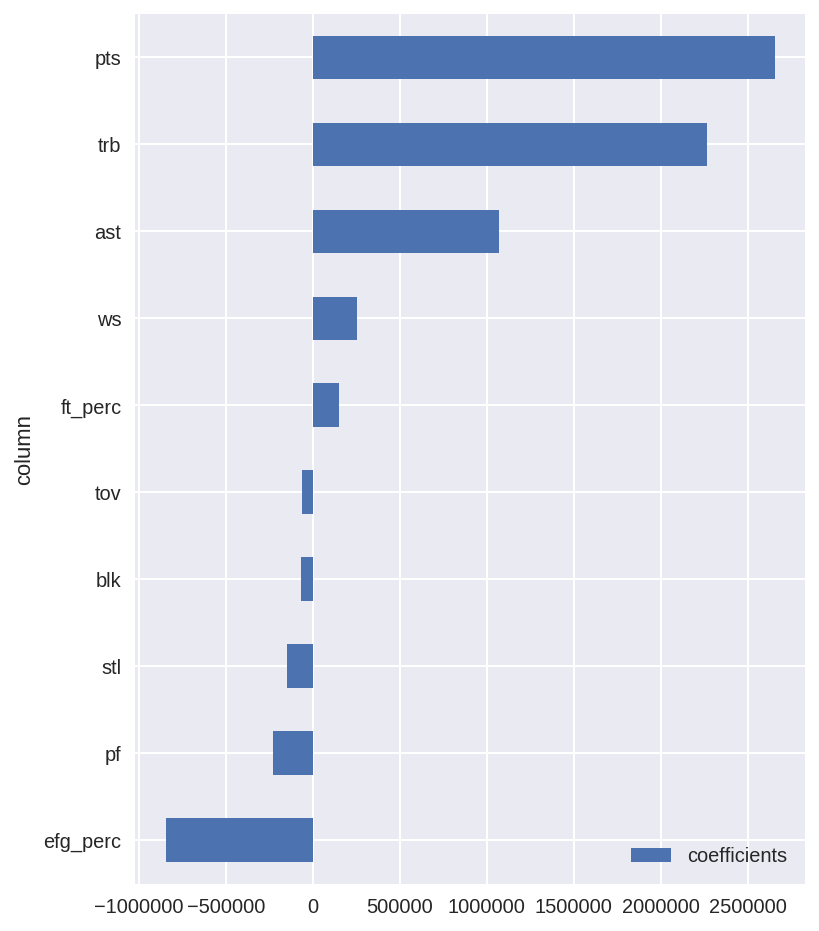

In [40]:
el_feat_importances = en_gs.best_estimator_.named_steps['regr'].coef_
el_cols_and_imps = list(zip(X_train.columns, el_feat_importances))
el_cols_and_imps.sort(key=lambda x:x[1], reverse=False)

el_feat_imp_df = pd.DataFrame(el_cols_and_imps)
el_feat_imp_df.rename(columns={1:'coefficients',0:'column'}, inplace=True)
el_feat_imp_df = el_feat_imp_df

el_feat_imp_df.plot.barh('column','coefficients', figsize=(6,8))
plt.show()

In [41]:
en_test_preds = en_gs.predict(X_test)
print('ElasticNet MAE:', mean_absolute_error(en_test_preds, y_test))
print('ElasticNet MSE:', mean_squared_error(en_test_preds, y_test))

ElasticNet MAE: 3678727.01558
ElasticNet MSE: 2.15903070242e+13


In [42]:
print('Linear MAE:', mean_absolute_error(linear_test_preds, y_test))
print('Linear MSE:', mean_squared_error(linear_test_preds, y_test))
print('ElasticNet MAE:', mean_absolute_error(en_test_preds, y_test))
print('ElasticNet MSE:', mean_squared_error(en_test_preds, y_test))

Linear MAE: 3565632.94528
Linear MSE: 2.12967758194e+13
ElasticNet MAE: 3678727.01558
ElasticNet MSE: 2.15903070242e+13


The ElasticNet didn't do that much better than the linear model. Actually, the basic linear model seems to have better scores and less error.

# Random Forest Model

Maybe the linear model isn't the best model for this data set. Now, let's try using a Random Forest which should have a lot of benefits for our data. It's a non-parametric model - so it can predict variables that are non-normally distributed - which is our data as salaries do not follow a normal distribution. 

Random Forests are a combination of tree predictors where each tree depends on the values of a random vector sampled independently with the same distribution for all trees in the forest. The basic principle is that a group of “weak learners” can come together to form a “strong learner”. Random Forests are a wonderful tool for making predictions considering they do not overfit because of the law of large numbers.

So let's implement this below and see how it does:

In [43]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [44]:
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(Lasso())),
    ('reg',RandomForestRegressor(random_state=42))
])

rf_params = {
    'reg__n_estimators':range(100,300,10),
    'reg__max_depth':[1,3,5,7,10,None],
    'sfm__estimator':[Lasso(), Ridge()]
}

rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, n_jobs=-1, cv=8, verbose=1)

In [45]:
rf_gs.fit(X_train,y_train)

Fitting 8 folds for each of 240 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  2.6min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False...estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'reg__n_estimators': range(100, 300, 10), 'reg__max_depth': [1, 3, 5, 7, 10, None], 'sfm__estimator': [Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)]},
       pre_dispatch='2*n_jobs', refit=

In [46]:
rf_gs.best_params_

{'reg__max_depth': 3,
 'reg__n_estimators': 180,
 'sfm__estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)}

In [47]:
rf_gs.best_score_

0.41594753683881547

In [48]:
rf_gs.score(X_train,y_train)

0.64616436678558231

In [49]:
rf_gs.score(X_test,y_test)

0.39121636920311659

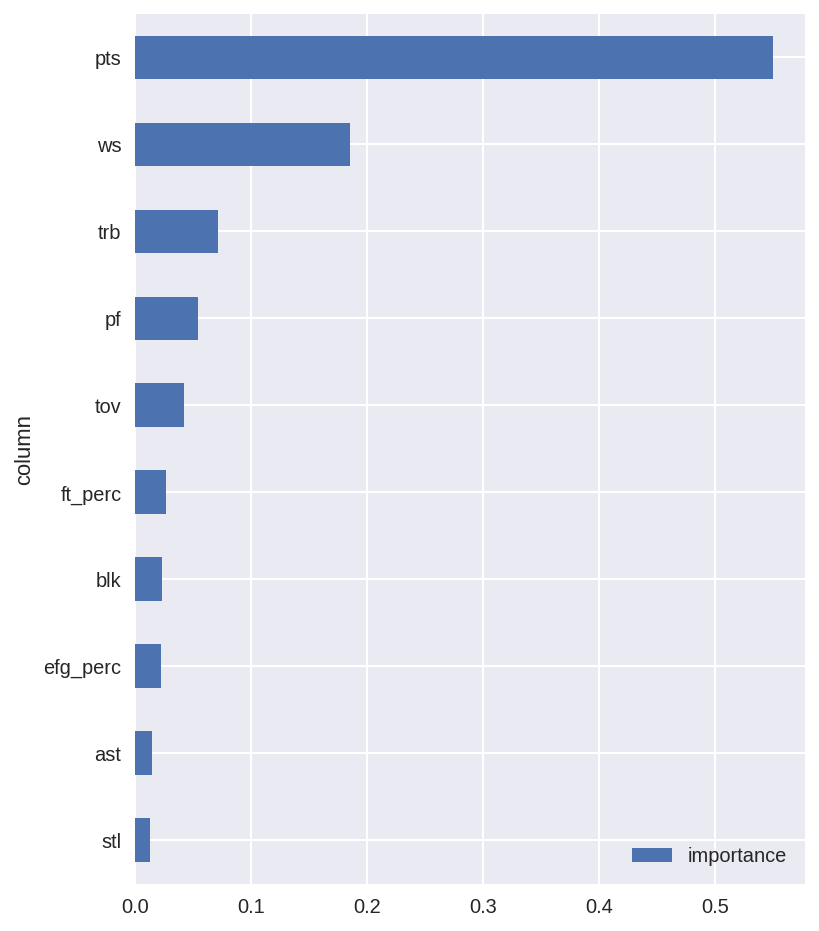

In [50]:
rf_feat_importances = rf_gs.best_estimator_.named_steps['reg'].feature_importances_
rf_cols_and_imps = list(zip(X_train.columns, rf_feat_importances))
rf_cols_and_imps.sort(key=lambda x:x[1], reverse=False)

rf_feat_imp_df = pd.DataFrame(rf_cols_and_imps)
rf_feat_imp_df.rename(columns={1:'importance',0:'column'}, inplace=True)
rf_feat_imp_df = rf_feat_imp_df

rf_feat_imp_df.plot.barh('column','importance', figsize=(6,8))
plt.show()

In [51]:
rf_test_preds = rf_gs.predict(X_test)
print('RandomForest MAE:', mean_absolute_error(rf_test_preds, y_test))
print('RandomForest MSE:', mean_squared_error(rf_test_preds, y_test))

RandomForest MAE: 3761305.89893
RandomForest MSE: 2.22943311871e+13


In [52]:
print('Linear MAE:', mean_absolute_error(linear_test_preds, y_test))
print('Linear MSE:', mean_squared_error(linear_test_preds, y_test))
print('ElasticNet MAE:', mean_absolute_error(en_test_preds, y_test))
print('ElasticNet MSE:', mean_squared_error(en_test_preds, y_test))
print('RandomForest MAE:', mean_absolute_error(rf_test_preds, y_test))
print('RandomForest MSE:', mean_squared_error(rf_test_preds, y_test))

Linear MAE: 3565632.94528
Linear MSE: 2.12967758194e+13
ElasticNet MAE: 3678727.01558
ElasticNet MSE: 2.15903070242e+13
RandomForest MAE: 3761305.89893
RandomForest MSE: 2.22943311871e+13


### Extra Tree Regressor

Going to try another tree method - Extra Trees. Seeing if this may produce better results than Random Forest. Looking at the results belows, since this has a very high training score but significantly lower test score, the model seems to be overfitting.

In [53]:
et_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(Lasso())),
    ('reg',ExtraTreesRegressor(random_state=42))
])

et_params = {
    'sfm__estimator':[Lasso(), Ridge()],
    'reg__n_estimators':range(50,240, 40),
    'reg__bootstrap':[False,True]
}

et_gs = GridSearchCV(et_pipe, param_grid=et_params, n_jobs=-1, cv=5, verbose=1)

In [54]:
et_gs.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False..._estimators=10, n_jobs=1, oob_score=False, random_state=42,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'reg__n_estimators': range(50, 240, 40), 'reg__bootstrap': [False, True], 'sfm__estimator': [Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)]},
       pre_dispatch='2*n_jobs', refit=True, retu

In [55]:
et_gs.best_params_

{'reg__bootstrap': True,
 'reg__n_estimators': 90,
 'sfm__estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)}

In [56]:
et_gs.best_score_

0.43874337513393608

In [57]:
et_gs.score(X_train,y_train)

0.92141016601555747

In [58]:
et_gs.score(X_test,y_test)

0.38823038452967862

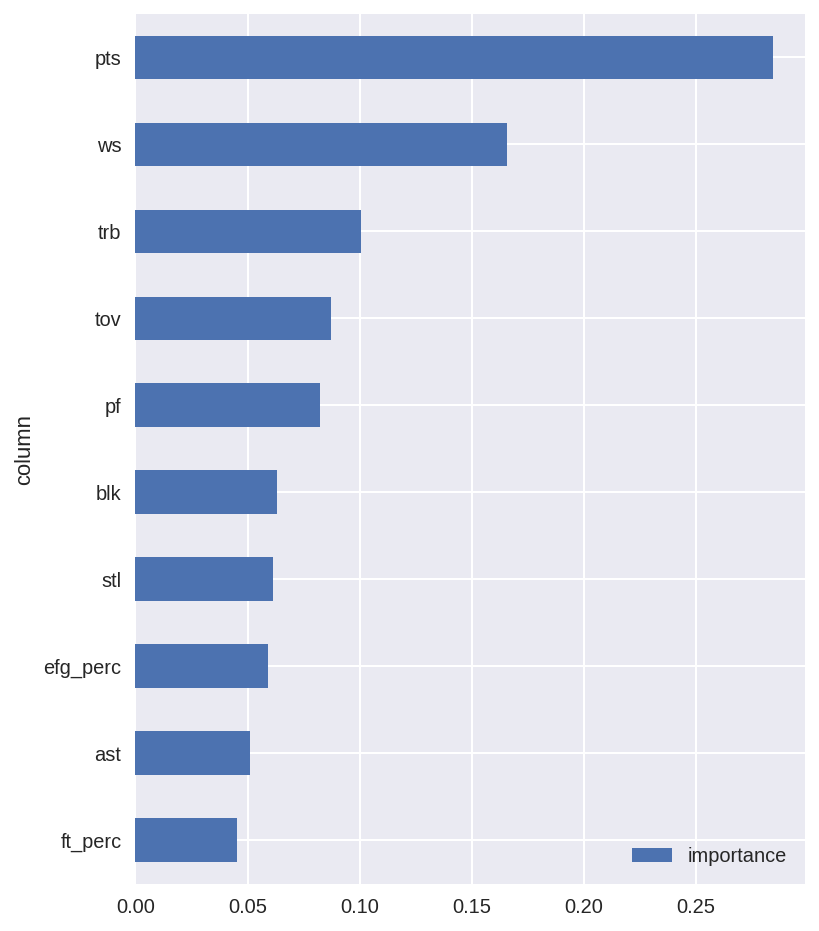

In [59]:
et_feat_importances = et_gs.best_estimator_.named_steps['reg'].feature_importances_
et_cols_and_imps = list(zip(X_train.columns, et_feat_importances))
et_cols_and_imps.sort(key=lambda x:x[1], reverse=False)

et_feat_imp_df = pd.DataFrame(et_cols_and_imps)
et_feat_imp_df.rename(columns={1:'importance',0:'column'}, inplace=True)
et_feat_imp_df = et_feat_imp_df

et_feat_imp_df.plot.barh('column','importance', figsize=(6,8))
plt.show()

In [60]:
et_test_preds = rf_gs.predict(X_test)
print('ExtraTrees MAE:', mean_absolute_error(et_test_preds, y_test))
print('ExtraTrees MSE:', mean_squared_error(et_test_preds, y_test))

ExtraTrees MAE: 3761305.89893
ExtraTrees MSE: 2.22943311871e+13


In [61]:
print('Linear MAE:', mean_absolute_error(linear_test_preds, y_test))
print('Linear MSE:', mean_squared_error(linear_test_preds, y_test))
print('ElasticNet MAE:', mean_absolute_error(en_test_preds, y_test))
print('ElasticNet MSE:', mean_squared_error(en_test_preds, y_test))
print('RandomForest MAE:', mean_absolute_error(rf_test_preds, y_test))
print('RandomForest MSE:', mean_squared_error(rf_test_preds, y_test))
print('ExtraTrees MAE:', mean_absolute_error(et_test_preds, y_test))
print('ExtraTrees MSE:', mean_squared_error(et_test_preds, y_test))

Linear MAE: 3565632.94528
Linear MSE: 2.12967758194e+13
ElasticNet MAE: 3678727.01558
ElasticNet MSE: 2.15903070242e+13
RandomForest MAE: 3761305.89893
RandomForest MSE: 2.22943311871e+13
ExtraTrees MAE: 3761305.89893
ExtraTrees MSE: 2.22943311871e+13


# Support Vector Regressor

Tried using a Support Vector Regressor model below but it doesn't sem to perform as well as the models above.

In [62]:
from sklearn.svm import SVR

In [63]:
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',SVR(kernel='rbf'))
])

svr_params = {
    'reg__C':np.linspace(1000,20000,10),
    'reg__gamma':np.linspace(0,100,10)
}

svr_gs = GridSearchCV(svr_pipe, svr_params, cv=10, verbose=1)

In [64]:
svr_gs.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    9.2s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'reg__C': array([  1000.     ,   3111.11111,   5222.22222,   7333.33333,
         9444.44444,  11555.55556,  13666.66667,  15777.77778,
        17888.88889,  20000.     ]), 'reg__gamma': array([   0.     ,   11.11111,   22.22222,   33.33333,   44.44444,
         55.55556,   66.66667,   77.77778,   88.88889,  100.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [65]:
svr_gs.best_params_

{'reg__C': 20000.0, 'reg__gamma': 11.111111111111111}

In [66]:
svr_gs.best_score_

-0.13210061853125649

In [67]:
svr_gs.score(X_train,y_train)

-0.092009314280157684

In [68]:
svr_gs.score(X_test,y_test)

-0.25913951121232248

In [69]:
svr_test_preds = svr_gs.predict(X_test)
print('SupportVector Regressor MAE:', mean_absolute_error(svr_test_preds, y_test))
print('SupportVector Regressor MSE:', mean_squared_error(svr_test_preds, y_test))

SupportVector Regressor MAE: 5241376.8099
SupportVector Regressor MSE: 4.61110842238e+13


In [70]:
print('Linear MAE:', mean_absolute_error(linear_test_preds, y_test))
print('Linear MSE:', mean_squared_error(linear_test_preds, y_test))
print('ElasticNet MAE:', mean_absolute_error(en_test_preds, y_test))
print('ElasticNet MSE:', mean_squared_error(en_test_preds, y_test))
print('RandomForest MAE:', mean_absolute_error(rf_test_preds, y_test))
print('RandomForest MSE:', mean_squared_error(rf_test_preds, y_test))
print('ExtraTrees MAE:', mean_absolute_error(et_test_preds, y_test))
print('ExtraTrees MSE:', mean_squared_error(et_test_preds, y_test))
print('SupportVector Regressor MAE:', mean_absolute_error(svr_test_preds, y_test))
print('SupportVector Regressor MSE:', mean_squared_error(svr_test_preds, y_test))

Linear MAE: 3565632.94528
Linear MSE: 2.12967758194e+13
ElasticNet MAE: 3678727.01558
ElasticNet MSE: 2.15903070242e+13
RandomForest MAE: 3761305.89893
RandomForest MSE: 2.22943311871e+13
ExtraTrees MAE: 3761305.89893
ExtraTrees MSE: 2.22943311871e+13
SupportVector Regressor MAE: 5241376.8099
SupportVector Regressor MSE: 4.61110842238e+13


# Neural Net | Keras

In [71]:
!pip install keras
!pip install tensorflow

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [72]:
import keras
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


Below we define the function to create the baseline model to be evaluated. It is a simple model that has a single fully connected hidden layer with the same number of neurons as input attributes (16). No activation function is used for the output layer because it is a regression problem and we are interested in predicting numerical values directly without transform.

The efficient ADAM optimization algorithm is used and a mean squared error loss function is optimized. This will be the same metric that we will use to evaluate the performance of the model. It is a desirable metric because by taking the square root gives us an error value we can directly understand in the context of the problem.

In [73]:
X_n = np.array(X)
y_n = np.array(y)

In [74]:
# define base model
def baseline_model():
    n_cols = X.shape[1]
    input_shape = (n_cols,)
    # create model
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=input_shape,kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

The Keras wrapper object for use in scikit-learn as a regression estimator is called KerasRegressor. We create an instance and pass it both the name of the function to create the neural network model as well as some parameters to pass along to the fit() function of the model later, such as the number of epochs and batch size. Both of these are set to sensible defaults.

In [75]:
seed = 42
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=1)

The final step is to evaluate this baseline model. We will use 10-fold cross validation to evaluate the model.

In [76]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_n, y_n, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/10
282/282 [==============================] - 0s - loss: 113277015616519.2656     
Epoch 2/10
282/282 [==============================] - 0s - loss: 113276977243099.6875     
Epoch 3/10
282/282 [==============================] - 0s - loss: 113276900043550.8594     
Epoch 4/10
282/282 [==============================] - 0s - loss: 113276780940004.7656     
Epoch 5/10
282/282 [==============================] - 0s - loss: 113276616670534.7969     
Epoch 6/10
282/282 [==============================] - 0s - loss: 113276402450548.2031     
Epoch 7/10
282/282 [==============================] - 0s - loss: 113276144692347.4688     
Epoch 8/10
282/282 [==============================] - 0s - loss: 113275855451767.8281     
Epoch 9/10
282/282 [==============================] - 0s - loss: 113275524794295.3750     
Epoch 10/10
282/282 [==============================] - 0s - loss: 112481893703738.0938     
Epoch 2/10
282/282 [==============================] - 0s - loss: 112481842382078.1875    

283/283 [==============================] - 0s - loss: 117895436840250.7969     
Epoch 7/10
283/283 [==============================] - 0s - loss: 117895107418799.5000     
Epoch 8/10
283/283 [==============================] - 0s - loss: 117894713565502.4219     
Epoch 9/10
283/283 [==============================] - 0s - loss: 117894272896806.8906     
Epoch 10/10
283/283 [==============================] - 0s - loss: 117967395425681.6406     
Epoch 2/10
283/283 [==============================] - 0s - loss: 117967340840446.2031     
Epoch 3/10
283/283 [==============================] - 0s - loss: 117967228841043.2188     
Epoch 4/10
283/283 [==============================] - 0s - loss: 117967033889274.5781     
Epoch 5/10
283/283 [==============================] - 0s - loss: 117966736994057.9375     
Epoch 6/10
283/283 [==============================] - 0s - loss: 117966351040280.4219     
Epoch 7/10
283/283 [==============================] - 0s - loss: 117965878736454.5625     
Epoch 8/1

In [77]:
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: 114266362870011.05 (28510156620533.01) MSE


In [78]:
def larger_model():
    n_cols = X.shape[1]
    input_shape = (n_cols,)
    # create model
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=input_shape,kernel_initializer='normal'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [79]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X_n, y_n, cv=kfold)

Epoch 1/50
282/282 [==============================] - 0s - loss: 113277015177753.4219     
Epoch 2/50
282/282 [==============================] - 0s - loss: 113276897402589.5000     
Epoch 3/50
282/282 [==============================] - 0s - loss: 113276400585793.3594     
Epoch 4/50
282/282 [==============================] - 0s - loss: 113275048261123.6406     
Epoch 5/50
282/282 [==============================] - 0s - loss: 113272329574995.5156     
Epoch 6/50
282/282 [==============================] - 0s - loss: 113267941719483.0156     
Epoch 7/50
282/282 [==============================] - 0s - loss: 113261577919175.7188     
Epoch 8/50
282/282 [==============================] - 0s - loss: 113252548326334.6406     
Epoch 9/50
282/282 [==============================] - 0s - loss: 113240284642514.6094     
Epoch 10/50
282/282 [==============================] - 0s - loss: 113224807314018.0469     
Epoch 11/50
282/282 [==============================] - 0s - loss: 113205241165664.2188   

282/282 [==============================] - 0s - loss: 109679998186895.4375     
Epoch 40/50
282/282 [==============================] - 0s - loss: 109485592605514.4375     
Epoch 41/50
282/282 [==============================] - 0s - loss: 109287683853493.5625     
Epoch 42/50
282/282 [==============================] - 0s - loss: 109083418951680.0000     
Epoch 43/50
282/282 [==============================] - 0s - loss: 108872176608568.2812    
Epoch 44/50
282/282 [==============================] - 0s - loss: 108652811434289.0312    
Epoch 45/50
282/282 [==============================] - 0s - loss: 108429151396827.6875     
Epoch 46/50
282/282 [==============================] - 0s - loss: 108194365228053.7812     
Epoch 47/50
282/282 [==============================] - 0s - loss: 107954368404400.1094    
Epoch 48/50
282/282 [==============================] - 0s - loss: 107707301687208.8438     
Epoch 49/50
282/282 [==============================] - 0s - loss: 107451509436328.8438     
Epo

282/282 [==============================] - 0s - loss: 112023125819856.7812     
Epoch 28/50
282/282 [==============================] - 0s - loss: 111889274816439.3750     
Epoch 29/50
282/282 [==============================] - 0s - loss: 111747055873496.0625     
Epoch 30/50
282/282 [==============================] - 0s - loss: 111595911715643.9219     
Epoch 31/50
282/282 [==============================] - 0s - loss: 111436347871783.9375     
Epoch 32/50
282/282 [==============================] - 0s - loss: 111266081050943.5469     
Epoch 33/50
282/282 [==============================] - 0s - loss: 111086262305116.5938     
Epoch 34/50
282/282 [==============================] - 0s - loss: 110899325559539.2969     
Epoch 35/50
282/282 [==============================] - 0s - loss: 110704113013404.1406     
Epoch 36/50
282/282 [==============================] - 0s - loss: 110501326093406.4062    
Epoch 37/50
282/282 [==============================] - 0s - loss: 110290731260848.1094     
E

283/283 [==============================] - 0s - loss: 113023466025408.6719     
Epoch 16/50
283/283 [==============================] - 0s - loss: 112992593791533.2344     
Epoch 17/50
283/283 [==============================] - 0s - loss: 112957828861908.5781     
Epoch 18/50
283/283 [==============================] - 0s - loss: 112919625951702.3906     
Epoch 19/50
283/283 [==============================] - 0s - loss: 112876551683459.1562     
Epoch 20/50
283/283 [==============================] - 0s - loss: 112829189095076.6250     
Epoch 21/50
283/283 [==============================] - 0s - loss: 112779397886111.2031     
Epoch 22/50
283/283 [==============================] - 0s - loss: 112725326426965.9375     
Epoch 23/50
283/283 [==============================] - 0s - loss: 112666087440789.2656     
Epoch 24/50
283/283 [==============================] - 0s - loss: 112604134050754.4844     
Epoch 25/50
283/283 [==============================] - 0s - loss: 112535343370891.2969     


283/283 [==============================] - 0s - loss: 117332332666851.0469     
Epoch 4/50
283/283 [==============================] - 0s - loss: 117330979851897.2188     
Epoch 5/50
283/283 [==============================] - 0s - loss: 117328283436860.5938     
Epoch 6/50
283/283 [==============================] - 0s - loss: 117323643262042.4688     
Epoch 7/50
283/283 [==============================] - 0s - loss: 117316333402538.9688     
Epoch 8/50
283/283 [==============================] - 0s - loss: 117306699848599.0625     
Epoch 9/50
283/283 [==============================] - 0s - loss: 117293815276475.2500     
Epoch 10/50
283/283 [==============================] - 0s - loss: 117277359402704.0625     
Epoch 11/50
283/283 [==============================] - 0s - loss: 117256174043599.1406     
Epoch 12/50
283/283 [==============================] - 0s - loss: 117230303906291.3281     
Epoch 13/50
283/283 [==============================] - 0s - loss: 117199682845272.6406     
Epoch 

283/283 [==============================] - 0s - loss: 114385804025132.3281     
Epoch 42/50
283/283 [==============================] - 0s - loss: 114156700098183.6875     
Epoch 43/50
283/283 [==============================] - 0s - loss: 113915791403594.1875     
Epoch 44/50
283/283 [==============================] - 0s - loss: 113669893754836.5781     
Epoch 45/50
283/283 [==============================] - 0s - loss: 113414296337158.3281     
Epoch 46/50
283/283 [==============================] - 0s - loss: 113157363100349.9531     
Epoch 47/50
283/283 [==============================] - 0s - loss: 112884545326597.4219     
Epoch 48/50
283/283 [==============================] - 0s - loss: 112617222576468.1250     
Epoch 49/50
283/283 [==============================] - 0s - loss: 112332875137139.7969     
Epoch 50/50
283/283 [==============================] - 0s - loss: 117967397545064.9375     
Epoch 2/50
283/283 [==============================] - 0s - loss: 117967293524843.6562     
E

In [80]:
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Larger: 108728723585380.73 (27098626712012.56) MSE


In [81]:
print('Linear MAE:', mean_absolute_error(linear_test_preds, y_test))
print('Linear MSE:', mean_squared_error(linear_test_preds, y_test))
print('ElasticNet MAE:', mean_absolute_error(en_test_preds, y_test))
print('ElasticNet MSE:', mean_squared_error(en_test_preds, y_test))
print('RandomForest MAE:', mean_absolute_error(rf_test_preds, y_test))
print('RandomForest MSE:', mean_squared_error(rf_test_preds, y_test))
print('ExtraTrees MAE:', mean_absolute_error(et_test_preds, y_test))
print('ExtraTrees MSE:', mean_squared_error(et_test_preds, y_test))
print('SupportVector Regressor MAE:', mean_absolute_error(svr_test_preds, y_test))
print('SupportVector Regressor MSE:', mean_squared_error(svr_test_preds, y_test))

Linear MAE: 3565632.94528
Linear MSE: 2.12967758194e+13
ElasticNet MAE: 3678727.01558
ElasticNet MSE: 2.15903070242e+13
RandomForest MAE: 3761305.89893
RandomForest MSE: 2.22943311871e+13
ExtraTrees MAE: 3761305.89893
ExtraTrees MSE: 2.22943311871e+13
SupportVector Regressor MAE: 5241376.8099
SupportVector Regressor MSE: 4.61110842238e+13


The mean squared error from the neural net model seemed to perform better than most of the other models but it still has more error than the simple linear model.

# Model Evaluation

Of all the models, it looks like the linear model with lasso regularization performed the best with the best R2 score, as well as the least amount of error.

The linear model gave an R2 value of 0.4185. In other words, roughly 42 percent of the variation in salaries is explained in the model by the variation in the statistical fields used.

From this, we could conclude that NBA players' salaries are not fully determined by their on-court performence. About 68% of variation in salaries is explained by other variables that aren't a part of this model. Probably things like how marketable a player is, fan appeal, etc. There is more that goes into a player's salary than just their on-court performence but 42% is still enough that players definitely need to pay attention to their play.

In [82]:
results_dict = {
    'MAE':[mean_absolute_error(linear_test_preds, y_test),
           mean_absolute_error(en_test_preds, y_test),
           mean_absolute_error(rf_test_preds, y_test),
           mean_absolute_error(et_test_preds, y_test),
           mean_absolute_error(svr_test_preds, y_test),
           'N/A'],
    'MSE':[mean_squared_error(linear_test_preds, y_test),
           mean_squared_error(en_test_preds, y_test),
           mean_squared_error(rf_test_preds, y_test),
           mean_squared_error(et_test_preds, y_test),
           mean_squared_error(svr_test_preds, y_test),
           results.std()],
    'R2':[lr_gs.score(X_test,y_test),
          en_gs.score(X_test,y_test),
          rf_gs.score(X_test,y_test),
          et_gs.score(X_test,y_test),
          svr_gs.score(X_test,y_test),
          'N/A']
}

columns = ['linear','elastic_net','random_forest','extra_trees','suppor_vector','neural_net']

In [83]:
results_dict

{'MAE': [3565632.945280964,
  3678727.0155798546,
  3761305.8989265333,
  3761305.8989265333,
  5241376.80990382,
  'N/A'],
 'MSE': [21296775819399.555,
  21590307024188.703,
  22294331187099.012,
  22294331187099.012,
  46111084223773.117,
  27098626712012.562],
 'R2': [0.41845627039469924,
  0.41044091478236638,
  0.39121636920311659,
  0.38823038452967862,
  -0.25913951121232248,
  'N/A']}

In [84]:
results_df = pd.DataFrame(results_dict).T
results_df.columns = columns
results_df

,linear,elastic_net,random_forest,extra_trees,suppor_vector,neural_net
MAE,3.56563e+06,3.67873e+06,3.76131e+06,3.76131e+06,5.24138e+06,N/A
MSE,2.12968e+13,2.15903e+13,2.22943e+13,2.22943e+13,4.61111e+13,2.70986e+13
R2,0.418456,0.410441,0.391216,0.38823,-0.25914,N/A


# Feature Importances

Taking the best model we have, the linear model with lasso regularization, we can analyze feature importances by examining the coefficients. When all features are on the same scale, the most important features should have the highest coefficients in the model, while features uncorrelated with the target variable should have coefficient values close to zero.

Points per game, total rebounds per game and assists per game proved to be the most statistically significant variables in determining player salary, however, turnovers was also a significant contributor with a high negative coefficient. All of these make sense: the more points, rebounds and assists and fewer turnovers a player has, the higher salary they'll have.

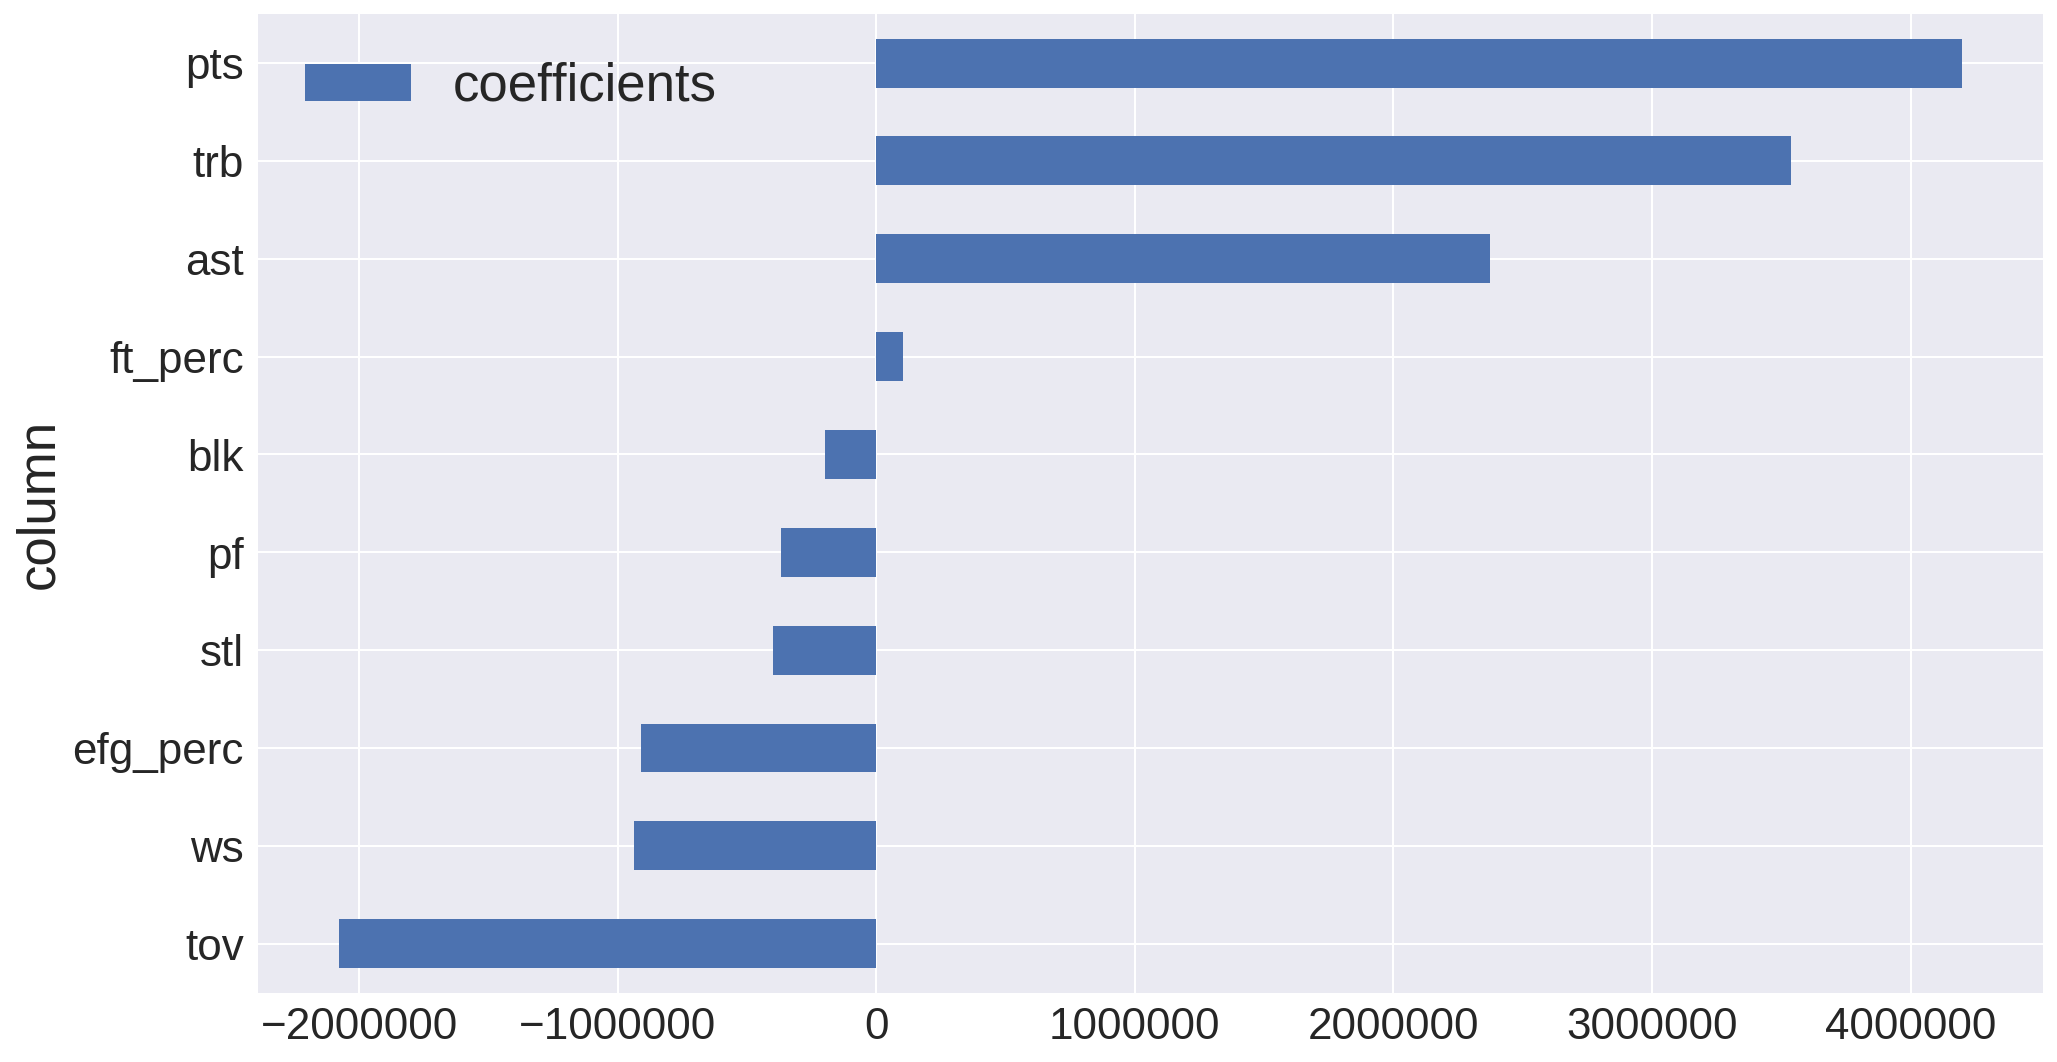

In [99]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

lr_feat_importances = lr_gs.best_estimator_.named_steps['regr'].coef_
lr_cols_and_imps = list(zip(X_train.columns, lr_feat_importances))
lr_cols_and_imps.sort(key=lambda x:x[1], reverse=False)

lr_feat_imp_df = pd.DataFrame(lr_cols_and_imps)
lr_feat_imp_df.rename(columns={1:'coefficients',0:'column'}, inplace=True)
lr_feat_imp_df = lr_feat_imp_df

lr_feat_imp_df.plot.barh('column','coefficients', figsize=(16,9))

plt.show()

### P-Values for statistical significance

We could see if a particular feature is statistically significant or not by looking at the p-values. Below I use the statsmodel library to produce an Ordinary Least Squares Regression report to quickly calculate p-values for all our statistical features.

In this case, the null hypothesis would be that there is no relationship between the particular feature and the target variable (salary). So the null hypothesis would assume that on-court-performence statistics are independent of salary. Therefore, if any particular feature has a low p-value, specifically lower than 0.05, then we say that particular feature is statistically significant and we reject the null hypothesis and conclude that there is a relationship between that feature and the target.

Examining the p-values, we see that points, total rebounds, assists, effective field goal percentage, turnovers and win-shares have p-values lower than 0.05.

But of these, the features that had the highest coefficient and the smallest p-values were:
- points
- total rebounds
- assists

So it would benefit a player if they focused their play on improving these particular statistics.

In [100]:
import statsmodels.api as sm
from scipy import stats

In [101]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     32.08
Date:                Thu, 14 Sep 2017   Prob (F-statistic):           5.22e-42
Time:                        00:00:45   Log-Likelihood:                -5265.9
No. Observations:                 314   AIC:                         1.055e+04
Df Residuals:                     303   BIC:                         1.060e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.68e+06   2.55e+06      1.052      0.2

###### Same stats model report in sklearn model

The stats model package uses ordinary least squares which is a little different from the linear model with lasso regularization that we built in sklearn. To ensure that we are remaining consistent in the model that we are evaluating, I built out the same report using our linear with lasso regularization model below using numpy, pandas and sklearn. Also, the stats model bases all of its predictions on the entire data set - it fits on the whole data set and then predicts on that same data set. For the purposes of our model, we want to know the p-values of our test data set as that is how we are scoring our model. 

The test data is significantly smaller than the entire data set and it contains 79 players, which isn't a whole lot. So the results of this second report may differ from the stats model report

In [102]:
X_test.reset_index(inplace=True)
X_test.drop('index',axis=1,inplace=True)

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [103]:
params = np.append(lr_gs.best_estimator_.named_steps['regr'].intercept_,lr_gs.best_estimator_.named_steps['regr'].coef_)
newX = pd.DataFrame({"Constant":np.ones(len(X_test))}).join(pd.DataFrame(X_test))
MSE = (sum((y_test-linear_test_preds)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]

myDF4 = myDF3.T
myDF4.columns = newX.columns
final_my_df = myDF4.T
final_my_df

,Coefficients,Standard Errors,t values,Probabilites
Constant,8.135541e+06,8.855644e+06,0.919,0.361
ast,2.374538e+06,8.924847e+05,2.661,0.009
blk,-1.989800e+05,1.917665e+06,-0.104,0.918
efg_perc,-9.111783e+05,1.159228e+07,-0.079,0.938
ft_perc,1.030918e+05,6.697666e+06,0.015,0.988
pf,-3.696629e+05,1.497037e+06,-0.247,0.806
pts,4.199424e+06,2.887020e+05,14.546,0.000
stl,-3.995851e+05,2.013341e+06,-0.198,0.843
tov,-2.077641e+06,2.767409e+06,-0.751,0.455
trb,3.538506e+06,3.986071e+05,8.877,0.000


# High Variance - Effect of Outliers

In the model, the actual salaries vary quite a bit from the predicted, both on the downside and the upside. What this says is that if this model is a base for what players are worth (which it is not, completely, due to fan appeal and other non-quantitative data), then some players are vastly overpaid while others are vastly underpaid. 

To show this, I'm going to take out just one outlier and examine the R2 results. In the 2016-2017 season, the highest paid player was Lebron James with the only salary over $30 million. Outliers like Lebron James definitely affect the model so let's take a look at a linear model without Lebron James in it.

The boxplot below shows the one highest outlier which is Lebron James.

The R2 score of this linear model is 0.468. In other words, 46.8 percent of the variation in salaries of NBA players other than Lebron is explained by the variations in the statistical categories used in this model.

Previously, with Lebron, the R2 score was 0.4185. So taking Lebron out helped our model by increasing explanatory power by about 5 percent.

With each team in the NBA, there are outliers like Lebron. And there is probably various reasons that they are outliers - but most likely their higher salaries are attributed to factors outside of the on-court performence statistics.

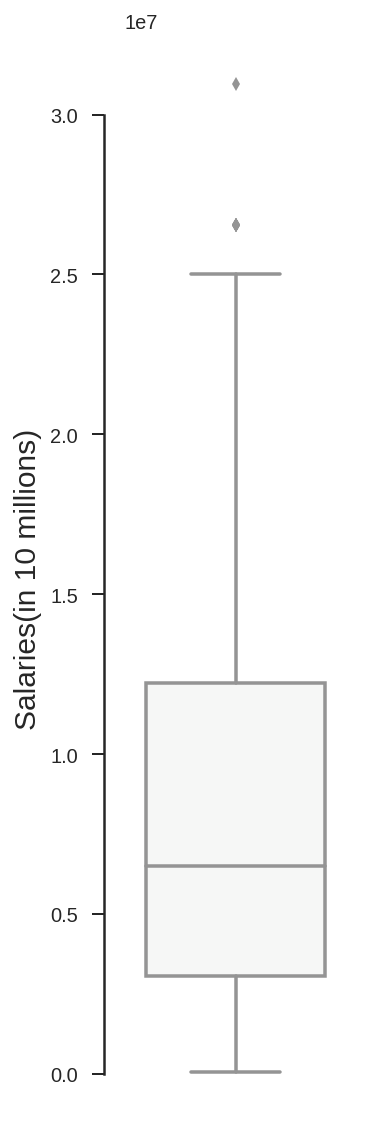

In [106]:
fig = plt.figure(figsize=(2,10)) 
ax = plt.gca()

sns.set(style="ticks")
sns.boxplot(y='salary', data=nba_df, palette="PRGn")
ax.set_ylabel('Salaries(in 10 millions)', fontsize=15)

sns.despine(offset=10, trim=True)

In [107]:
nba_df[nba_df['salary'] > 30000000]

,ast,blk,efg_perc,ft_perc,pf,pts,salary,stl,tov,trb,ws
293,8.72973,0.594595,0.594,0.674,1.810811,26.405405,30963450.0,1.243243,4.094595,8.635135,12.9


In [108]:
no_lebron = nba_df[nba_df['salary'] < 30000000]
X_wo_lebron = no_lebron.drop('salary',axis=1)
y_wo_lebron = no_lebron['salary']

In [109]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_wo_lebron, y_wo_lebron, test_size=0.25, random_state=42)

In [110]:
lr_pipe_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(Lasso())),
    ('regr', lm.LinearRegression())
])

lr_params_2 = {
    'sfm__estimator':[Lasso(), Ridge()]
}

lr_gs_2 = GridSearchCV(lr_pipe_2,lr_params_2,n_jobs=-1,cv=10)

In [111]:
lr_gs_2.fit(X_train_2,y_train_2)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
        prefit=False, threshold=None)), ('regr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'sfm__estimator': [Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verb

In [112]:
print(lr_gs_2.best_score_)
print(lr_gs_2.best_params_)

0.367654139998
{'sfm__estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)}


In [113]:
lr_gs_2.score(X_train,y_train)

0.51359862937100975

In [114]:
lr_gs_2.score(X_test,y_test)

0.46800090964454955

In [115]:
lebron_predicted = lr_gs_2.predict(X_test)

In [116]:
results_dict_2 = {
    'MAE':[mean_absolute_error(linear_test_preds, y_test),
           mean_absolute_error(lebron_predicted, y_test),
           mean_absolute_error(en_test_preds, y_test),
           mean_absolute_error(rf_test_preds, y_test),
           mean_absolute_error(et_test_preds, y_test),
           mean_absolute_error(svr_test_preds, y_test),
           'N/A'],
    'MSE':[mean_squared_error(linear_test_preds, y_test),
           mean_squared_error(lebron_predicted, y_test),
           mean_squared_error(en_test_preds, y_test),
           mean_squared_error(rf_test_preds, y_test),
           mean_squared_error(et_test_preds, y_test),
           mean_squared_error(svr_test_preds, y_test),
           results.std()],
    'R2':[lr_gs.score(X_test,y_test),
          lr_gs_2.score(X_test,y_test),
          en_gs.score(X_test,y_test),
          rf_gs.score(X_test,y_test),
          et_gs.score(X_test,y_test),
          svr_gs.score(X_test,y_test),
          'N/A']
}

columns_2 = ['linear','linear_lebron_effect','elastic_net','random_forest','extra_trees','suppor_vector','neural_net']

In [117]:
results_df_2 = pd.DataFrame(results_dict_2).T
results_df_2.columns = columns_2
results_df_2

,linear,linear_lebron_effect,elastic_net,random_forest,extra_trees,suppor_vector,neural_net
MAE,3.56563e+06,3.50271e+06,3.67873e+06,3.76131e+06,3.76131e+06,5.24138e+06,N/A
MSE,2.12968e+13,1.94824e+13,2.15903e+13,2.22943e+13,2.22943e+13,4.61111e+13,2.70986e+13
R2,0.418456,0.468001,0.410441,0.391216,0.38823,-0.25914,N/A


# Residual Analysis

Residuals are estimates of experimental error obtained by subtracting the observed responses from the predicted responses. 

The predicted response is calculated from the chosen model, after all the unknown model parameters have been estimated from the experimental data. Carefully looking at residuals can tell us whether our assumptions are reasonable and our choice of model is appropriate.

Residuals can be thought of as elements of variation unexplained by the fitted model. Since this is a form of error, the same general assumptions apply to the group of residuals that we typically use for errors in general: one expects them to be (roughly) normal and (approximately) independently distributed with a mean of 0 and some constant variance.

In [118]:
residuals = list(zip(linear_test_preds,y_test))
residuals_df = pd.DataFrame(residuals, columns=['predicted','actual'])
residuals_df['residual'] = residuals_df['predicted'] - residuals_df['actual']

In [119]:
residuals_df['residual'] = residuals_df['predicted'] - residuals_df['actual']
residuals_df.head()

,predicted,actual,residual
0,-2.491782e+06,7491274.0,-9.983056e+06
1,4.643798e+06,7000000.0,-2.356202e+06
2,5.025655e+06,1015696.0,4.009959e+06
3,8.524096e+06,11242000.0,-2.717904e+06
4,1.056951e+07,13219250.0,-2.649743e+06


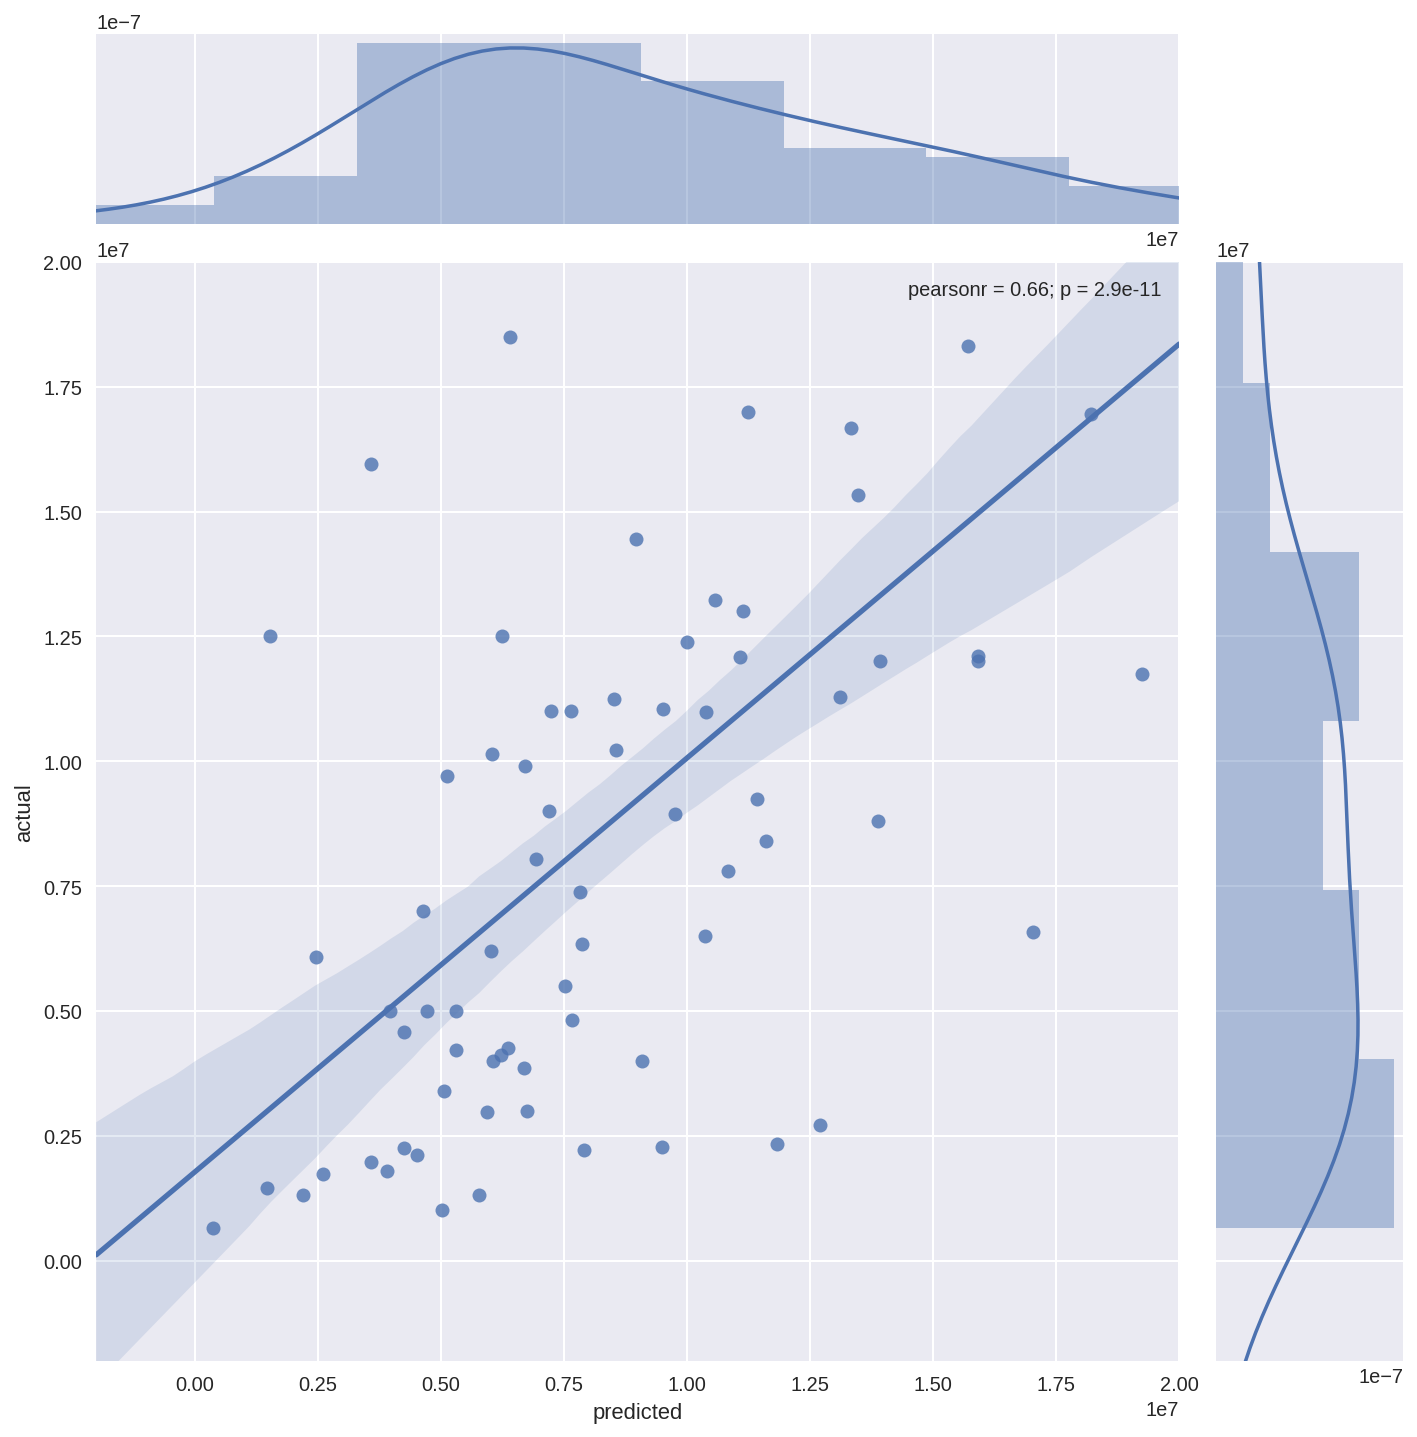

In [120]:
sns.set(style="darkgrid", color_codes=True)

sns.jointplot('predicted', "actual", data=residuals_df, kind="reg",
                  xlim=(-2000000, 20000000), ylim=(-2000000, 20000000), color="b", size=10)

plt.show()

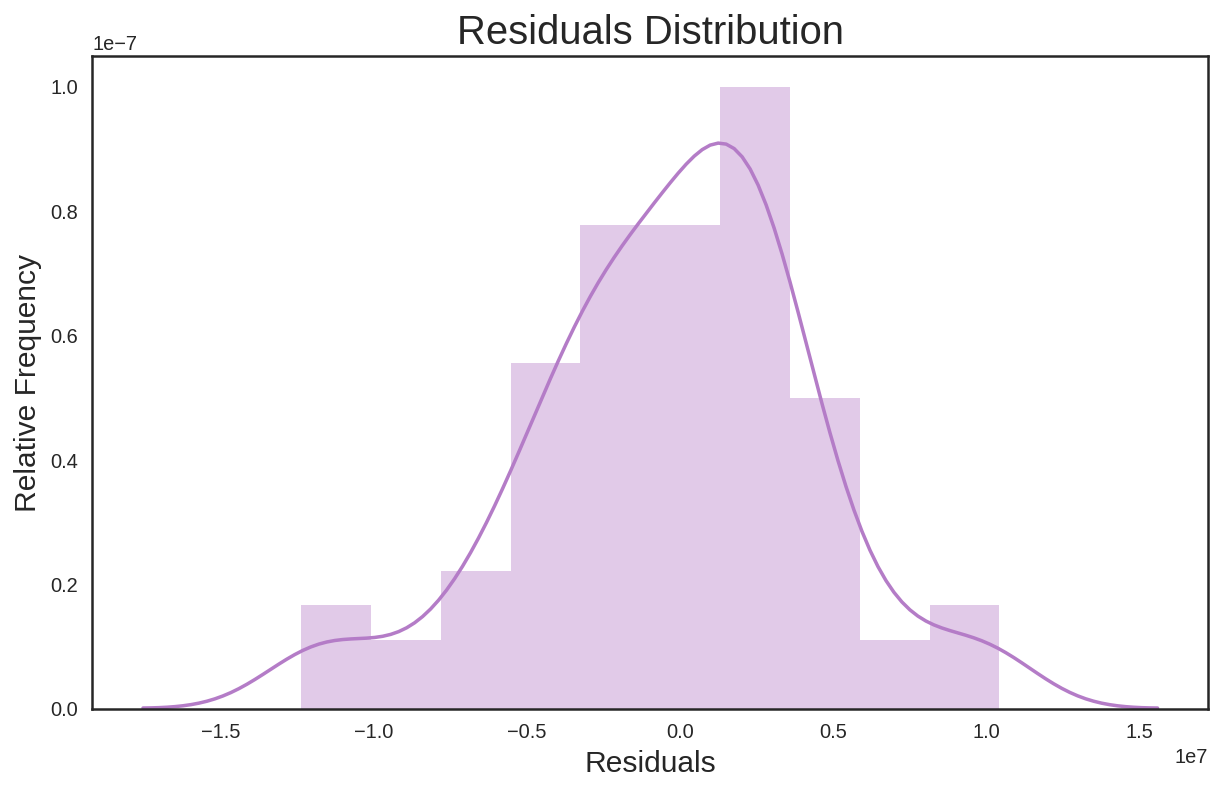

In [123]:
fig = plt.figure(figsize=(10,6)) 
ax = plt.gca()

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(residuals_df['residual'], color="m")

ax.set_title('Residuals Distribution',size=20)
ax.set_ylabel('Relative Frequency', fontsize=15)
ax.set_xlabel('Residuals', fontsize=15)
plt.show()